<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_VectorQuantized_single_cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE for clustering data

Neural Discrete Representation Learning: https://arxiv.org/abs/1711.00937  
Generating Diverse High-Fidelity Images with VQ-VAE-2: https://arxiv.org/abs/1906.00446

VQ-VAE example: https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb



In [2]:
!pip install scanpy

In [0]:
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix

import h5py
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import seaborn as sns; sns.set()
import keras.backend as K

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('ggplot')

In [0]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

# Create some data

In [0]:
def import_data_fn(string):
    data_mat = h5py.File(string)
    x_data = np.array(data_mat['X'])
    y_data = np.array(data_mat['Y'])
    return x_data, y_data, np.where(x_data > 0.0, 1, 0)

In [220]:
X_1, y_1, Z_1 = import_data_fn('10X_PBMC.h5')
print(X_1.shape)
X_2, y_2, Z_2 = import_data_fn('mouse_bladder_cell.h5')
print(X_2.shape)
# X_3, y_3, Z_3 = import_data_fn('worm_neuron_cell.h5')
# X_3, y_3, Z_3 = np.delete(X_3, 2682, axis=0), np.delete(y_3, 2682, axis=0), np.delete(Z_3, 2682, axis=0)
# print(X_3.shape)

(4271, 16653)
(2746, 20670)


NameError: ignored

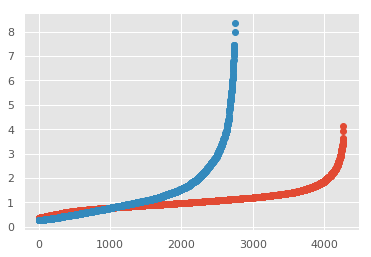

In [221]:
plt.plot(np.sort(np.mean(X_1, axis=1)/np.median(np.mean(X_1, axis=1))), 'o');
plt.plot(np.sort(np.mean(X_2, axis=1)/np.median(np.mean(X_2, axis=1))), 'o');
plt.plot(np.sort(np.mean(X_3, axis=1)/np.median(np.mean(X_3, axis=1))), 'o');
plt.xlabel('cells');
plt.ylabel('mean over genes/median');
plt.legend(('pbmc', 'bladder', 'neuron'))

NameError: ignored

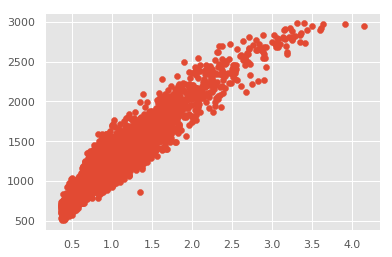

In [56]:
plt.scatter(np.mean(X_1, axis=1)/np.median(np.mean(X_1, axis=1)), np.sum(Z_1, axis=1))
plt.scatter(np.mean(X_2, axis=1)/np.median(np.mean(X_2, axis=1)), np.sum(Z_2, axis=1))
plt.scatter(np.mean(X_3, axis=1)/np.median(np.mean(X_3, axis=1)), np.sum(Z_3, axis=1))
plt.xlabel('mean over genes/median')
plt.ylabel('sum of non-zero genes')
plt.legend(('pbmc', 'bladder', 'neuron'))

In [0]:
p1 = []
pn1 = []
for i in range(50):
  lim = i
  pn1.append(lim)
  n = Z_1.shape[1]-np.argwhere(np.sum(Z_1, axis=0)>lim).shape[0]
  p1.append(n)

p2 = []
pn2 = []
for i in range(50):
  lim = i
  pn2.append(lim)
  n = Z_2.shape[1]-np.argwhere(np.sum(Z_2, axis=0)>lim).shape[0]
  p2.append(n)  
  
# p3 = []
# pn3 = []
# for i in range(50):
#   lim = i
#   pn3.append(lim)
#   n = Z_3.shape[1]-np.argwhere(np.sum(Z_3, axis=0)>lim).shape[0]
#   p3.append(n) 

ValueError: ignored

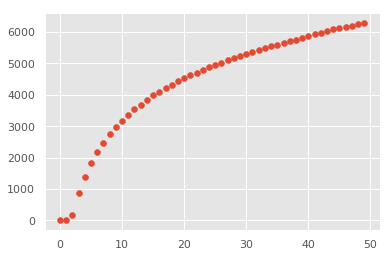

In [58]:
plt.scatter(pn1, p1);
plt.scatter(pn2, p2);
plt.scatter(pn3, p3);
plt.xlabel('n cells');
plt.ylabel('number of genes with n cells or less');
plt.legend(('pbmc', 'bladder', 'neuron'))

In [0]:
def remove_genes(X, Z, n):
  indx = np.argwhere(np.sum(Z, axis=0)>n)
  X1 = np.squeeze(X[:, indx])
  Z1 = np.squeeze(Z[:, indx])
  return X1, Z1

In [60]:
print(X_1.shape)
print(X_2.shape)
print(X_3.shape)

(4271, 16653)


NameError: ignored

In [0]:
X_1, Z_1 = remove_genes(X_1, Z_1, 5)
X_2, Z_2 = remove_genes(X_2, Z_2, 5)
# X_3, Z_3 = remove_genes(X_3, Z_3, 5)

In [224]:
print(X_1.shape)
print(X_2.shape)
# print(X_3.shape)

(4271, 14835)
(2746, 14483)


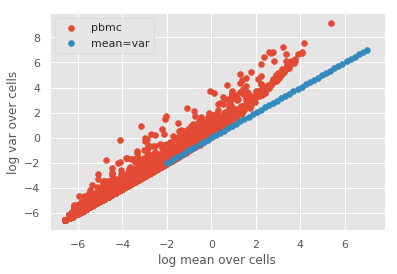

In [63]:
xp = np.linspace(-2,7)
plt.scatter(np.log(np.mean(X_1, axis=0)), np.log(np.var(X_1, axis=0)));
plt.scatter(xp, xp);
plt.xlabel('log mean over cells');
plt.ylabel('log var over cells');
plt.legend(('pbmc', 'mean=var'));

In [64]:
xp = np.linspace(-2,4)
plt.scatter(np.log(np.mean(X_2, axis=0)), np.log(np.var(X_2, axis=0)));
plt.scatter(xp, xp);
plt.xlabel('log mean over cells');
plt.ylabel('log var over cells');
plt.legend(('bladder', 'mean=var'));

NameError: ignored

In [18]:
xp = np.linspace(-3,2)
plt.scatter(np.log(np.mean(X_3, axis=0)), np.log(np.var(X_3, axis=0)));
plt.scatter(xp, xp);
plt.xlabel('log mean over cells');
plt.ylabel('log var over cells');
plt.legend(('neuron', 'mean=var'));

NameError: ignored

In [0]:
def adjust(X, do):
  if do:
    return (X-np.mean(X, axis=0))/np.std(X, axis=0)
  else:
    return X

In [0]:
s_1 = np.sum(X_1, axis=1)
# s_2 = np.sum(X_2, axis=1)
# s_3 = np.sum(X_3, axis=1)

# Define Encoder & Decoder


In [0]:
class Encoder(snt.AbstractModule):
  def __init__(self, name='encoder'):
    super(Encoder, self).__init__(name=name)
    
  def _build(self, x):
    h = snt.Linear(256)(x)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(16)(h)
    h = tf.reshape(h, shape=(-1, 16))
    return h

class Decoder(snt.AbstractModule):
  def __init__(self, output_dim, name='decoder'):
    super(Decoder, self).__init__(name=name)
    self.output_dim = output_dim
  
  def _build(self, x):
    h = tf.reshape(x, shape=(-1, 16))
    h = snt.Linear(16)(h)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(256)(h)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(self.output_dim, use_bias=False)(h)
    h = tf.clip_by_value(tf.math.softplus(h), 1e-5, 1e6)
    return h

# Build Graph and train

In [389]:
X_2.shape

(2746, 14483)

In [227]:
s_2.shape

NameError: ignored

In [277]:
X_2.shape

(2746, 14483)

In [0]:
randc = np.random.choice(X_2.shape[0], size=2746, replace=False)
X = adjust(X_2, False)[randc, :]
s = np.sum(X_2, axis=-1)[randc]
s = s.reshape(-1,1)

In [279]:
s.shape

(2746, 1)

In [278]:
X.shape

(2746, 14483)

In [424]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 25

num_training_updates = 40000
embedding_dim = 16
# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 20

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 9e-4

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices((X, X, s))
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()

def get_samples(sess, subset='train'):
    return sess.run(train_dataset_batch)

# Build modules.
encoder = Encoder()
decoder = Decoder(X.shape[1])

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x_in = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
x_out = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
s_mult = tf.placeholder(tf.float32, shape=(None, 1))

z = encoder(x_in)
# For training
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
#x_recon = decoder(z)
x_recon = s_mult*x_recon

recon_error = -tf.reduce_mean(tfd.Poisson(rate=x_recon).log_prob(x_out))
#recon_error = tf.reduce_mean(tf.square(x_out-x_recon))
loss = recon_error + vq_output_train["loss"]

# For evaluation, make sure is_training=False!
vq_output_eval = vq_vae(z, is_training=False)
x_recon_eval = decoder(vq_output_eval["quantize"])

# The following is a useful value to track during training.
# It indicates how many codes are 'active' on average.
perplexity = vq_output_train["perplexity"] 

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.train.SingularMonitoredSession()

# Train.
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
  a, b, c = get_samples(sess)
  feed_dict = {x_in: a, x_out: b, s_mult: c}
  results = sess.run([train_op, recon_error, perplexity],
                     feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 500 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-200:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-200:]))
    print()


500 iterations
recon_error: 0.979
perplexity: 3.839

1000 iterations
recon_error: 0.575
perplexity: 4.278

1500 iterations
recon_error: 0.461
perplexity: 4.253

2000 iterations
recon_error: 0.408
perplexity: 4.270

2500 iterations
recon_error: 0.383
perplexity: 4.274

3000 iterations
recon_error: 0.365
perplexity: 4.297

3500 iterations
recon_error: 0.948
perplexity: 4.295

4000 iterations
recon_error: 1.256
perplexity: 5.583

4500 iterations
recon_error: 0.675
perplexity: 7.136

5000 iterations
recon_error: 0.629
perplexity: 7.118

5500 iterations
recon_error: 0.561
perplexity: 7.129

6000 iterations
recon_error: 0.489
perplexity: 7.305

6500 iterations
recon_error: 0.538
perplexity: 7.800

7000 iterations
recon_error: 0.497
perplexity: 7.764

7500 iterations
recon_error: 0.608
perplexity: 6.514

8000 iterations
recon_error: 0.531
perplexity: 6.900

8500 iterations
recon_error: 0.477
perplexity: 7.139

9000 iterations
recon_error: 0.462
perplexity: 7.241

9500 iterations
recon_error: 

KeyboardInterrupt: ignored

# Plot loss

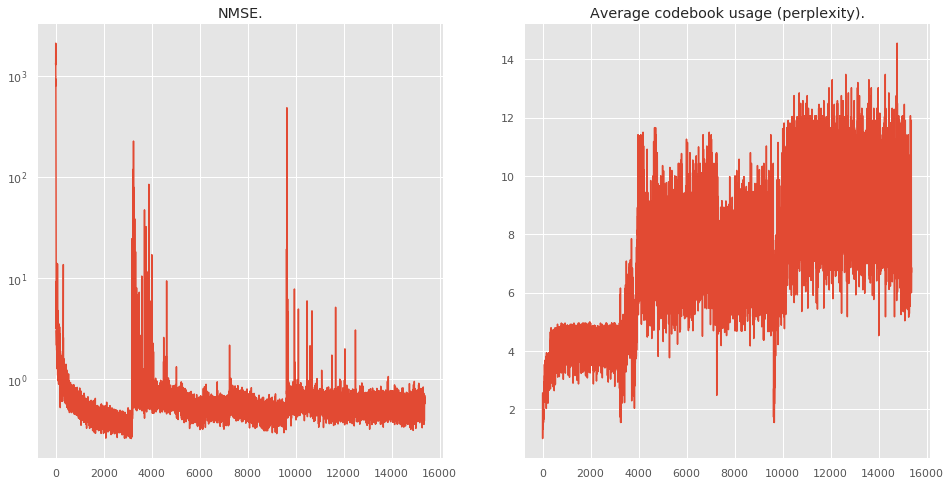

In [425]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).');

# View latent space

In [0]:
# Latent space
z_, vq_output_eval_, x_recon_, z_d_  = sess.run([z, vq_output_eval, x_recon, vq_output_train["quantize"]], feed_dict={x_in: X, x_out: X, s_mult: s})

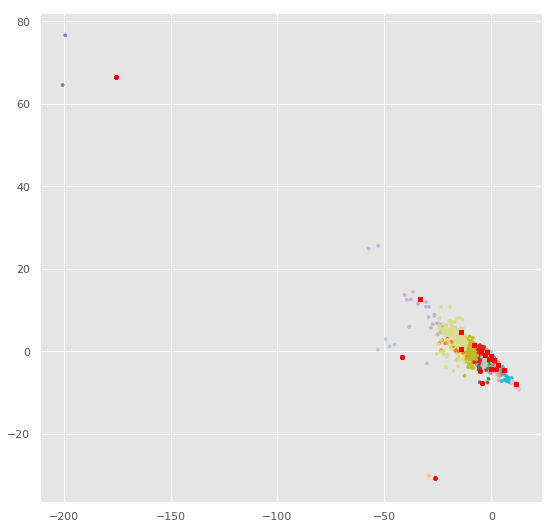

In [427]:
plt.figure(figsize=(9,9))
plt.scatter(z_[:,0], z_[:,1], c=vq_output_eval_['encoding_indices'], cmap='tab20', s=10.0);
plt.scatter(z_d_[:,0], z_d_[:,1], c='red', s=20.0);

In [0]:
true_labels = np.concatenate((y_2[randc][:,None],y_2[randc][:,None], y_2[randc][:,None],y_2[randc][:,None], y_2[randc][:,None],y_2[randc][:,None], y_2[randc][:,None],y_2[randc][:,None], y_2[randc][:,None],y_2[randc][:,None], y_2[randc][:,None],y_2[randc][:,None], y_2[randc][:,None],y_2[randc][:,None], y_2[randc][:,None],y_2[randc][:,None]), axis=1)

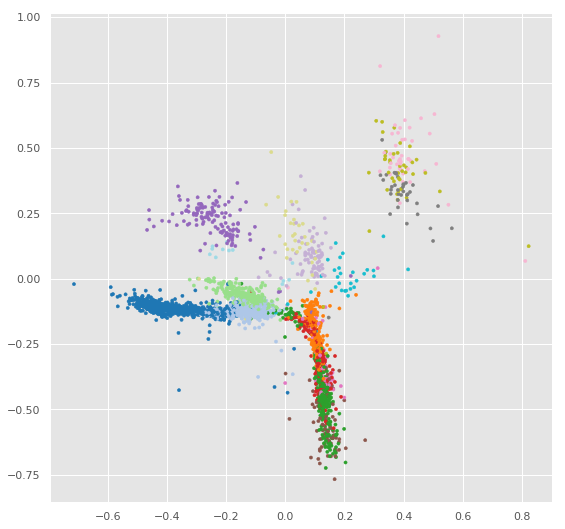

In [422]:
plt.figure(figsize=(9,9))
plt.scatter(z_[:,0], z_[:, 1], cmap='tab20', c=np.reshape(y_2[randc], -1), s=10.0);
#plt.scatter(z_d_[:,0], z_d_[:,1], c='red', s=20.0);